# <center> Introduction to Model-Free Reinforcement Learning</center>

(Feb 4 version)


# 1. Setup

#### Make sure that all the required dependencies are installed

In [1]:
import sys
!{sys.executable} -m pip install gym

In [2]:
!git clone https://github.com/Tobias-Fischer/RVSS2022.git

Cloning into 'RVSS2022'...
remote: Enumerating objects: 738, done.
remote: Counting objects: 100% (738/738), done.
remote: Compressing objects: 100% (605/605), done.
remote: Total 738 (delta 414), reused 352 (delta 125), pack-reused 0
Receiving objects: 100% (738/738), 39.57 MiB | 11.16 MiB/s, done.
Resolving deltas: 100% (414/414), done.
Checking out files: 100% (139/139), done.


#### Import all dependencies

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pickle
import math

import sys
import os
sys.path.insert(0, os.path.abspath('RVSS2022/Reinforcement_Learning/Support'))

from gym_simple_gridworlds.envs.grid_env import GridEnv
from gym_simple_gridworlds.envs.grid_2dplot import *
from gym_simple_gridworlds.helper import *
from gym_simple_gridworlds.dp_algorithms import *

from collections import namedtuple, defaultdict
import matplotlib.gridspec as gridspec

from IPython.core.display import display, HTML, Image

# 2. Temporal Difference Learning - Value Function Approximation 

Recall the grid in which our robot lives

![](https://raw.githubusercontent.com/Tobias-Fischer/RVSS2022/main/Reinforcement_Learning/Support/images/GridWorldExample.png)

- The states $s \in \mathcal{S}$ correspond to locations in the grid. Each location has also a cell index associated to it, e.g., cell index 4 is associated to location (row=1,col=0)
- The robot can move up, down, left, or right. Actions correpond to unit increments or decrements in the specified direction.
    - Up : (-1,0)
    - Down: (1,0)
    - Left: (0,-1)
    - Right: (0, 1)
- Each action is represented by a number. Action (Up) is represented by 0, (Down) by 1, (Left) by 2 and, finally, (Right) by 3. No actions are available at a terminal state
- Discount factor $\gamma = 0.99$ (class attribute ``gamma=0.99``)
- Stochastic transition matrix (class attribute ``noise=0.2``)
- Rewards are obtained at terminal states, and there is a running cost (class attribute ``living_reward=-0.04``)

This environment is represented with the class ``GridEnv``. **To a look at the attributes of this class, place the cursor somewhere on the class' name and hit SHIFT+TAB. If there's a + button at the top of the popup tooltip, this means the documentation spans a few lines, click it to show the full docstring, then scroll up.**

### Known Model

Recall also the **optimal policy** we found yesterday using policy-interation

![](https://raw.githubusercontent.com/Tobias-Fischer/RVSS2022/main/Reinforcement_Learning/Support/images/example_policy.png)

since the dynamics of our grid world environment are known, we obtained the state-value function $v_\pi(s)$ associated to this policy using ``policy_evalution(.)`` 

We have defined the class ``GridEnv`` to represent our Grid World MDP. **Take a look at the attributes of this class by placing the cursor somewhere on the class' name and hit SHIFT+TAB. If there's a + button at the top of the popup tooltip, this means the documentation spans a few lines, click it to show the full docstring, then scroll up.**

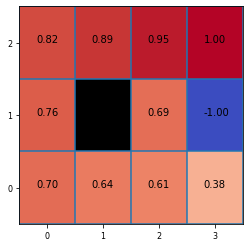

In [4]:
# Create a Grid World instance
grid_world = GridEnv(gamma=0.99, noise=0.2, living_reward=-0.04)

# Get policy shown in image
policy_pi = encode_policy(grid_world)

# Compute value-function using dynamic programming
v_pi = policy_evaluation(grid_world, policy_pi)

plot_value_function(grid_world, v_pi)

plt.show()

### What if the Transition and Reward Function are Unknown?

Let's first define the helper method ``generate_episode(.)``. It samples an episode i.e., a sequence of ($s, a, r, s'$) tuples, from a given policy

In [5]:
Sample = namedtuple('Sample', ['state', 'action', 'reward', 'next_state'])

def generate_episode(grid_env, policy):
    """
    Generate an episode of experiences in environment under a given policy
    :param grid_env (GridEnv): Environment
    :param policy (dict of probabilites): Policy used to sample actions
    
    :return List(Sample) Complete episode
    """
    episode = []

    # Reset the environment to a random initial state
    state = grid_env.reset()

    # Set flag to indicate whether episode has ended
    done = False

    while not done:
        # Get actions available at current state
        all_actions = list(policy_pi[state].keys())
        # Get action probabilities
        all_probabilities = np.array(list(policy[state].values()))
        # Sample an action from policy
        action = np.random.choice(all_actions, 1, p=all_probabilities)[0]
        
        next_state, reward, done, info = grid_env.step(action)
        episode.append(Sample(state, action, reward, next_state))
        state = next_state

    return episode

Now, under the assumption that $\mathcal{T}(s,a,s')$ and $\mathcal{R}(s,a)$ are unknown, let's use the algorithm shown below to get an estimate $\hat{v}_\pi(s)$ of the true state-value function $v_\pi(s)$

![](https://raw.githubusercontent.com/Tobias-Fischer/RVSS2022/main/Reinforcement_Learning/Support/images/TDPolicyEvaluation.png)

In [6]:
def temporal_learning_policy_evaluation(grid_env, policy, true_v, alpha=0.1, n_episodes=1):
    """
    Compute estimate of state-value function for a given policy
    :param grid_env (GridEnv): Environment
    :param policy (dict of probabilites): Policy to be evaluated
    :param true_v (dict of floats): True state-value function. Used to compute prediciton error
    :param alpha (float): step-size
    :param n_episodes (int): Number of episodes to use for prediction
    
    :return List(float): Prediction error after each episode
    :return dict(float): Predicted state-value function
    
    """
    all_states = grid_env.get_states()
    
    # Predicted state-value function
    pred_v = {s:0 for s in all_states}
    
    # Variable used for plotting
    list_errors = []
    
    for i in range(n_episodes):
        # Generate episode
        episode = generate_episode(grid_env, policy)
        
        # Variable used to keep track of prediction error for this episode
        error = 0
        
        # Starting from the first sampled observation in episode
        for obs in episode:
            pred_v[obs.state] += alpha * (obs.reward + grid_env.gamma * pred_v[obs.next_state] - pred_v[obs.state]) 
            error += np.abs(true_v[obs.state] - pred_v[obs.state])       
        
        list_errors.append(error)
    
    return list_errors, pred_v

Let's now try the algorithm and compare its output to the true value-state function. 

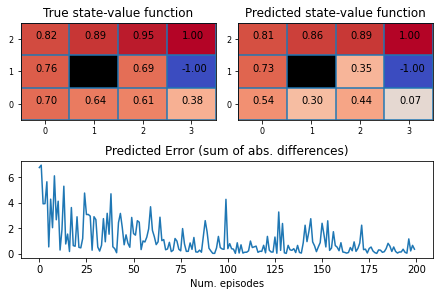

In [7]:
errors, predicted_v = temporal_learning_policy_evaluation(grid_world, policy_pi, v_pi, alpha=0.1, n_episodes=200)

fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
f_ax1 = fig.add_subplot(spec[0, 0])
f_ax2 = fig.add_subplot(spec[0, 1])
f_ax3 = fig.add_subplot(spec[1, :])

#Plot true value function
plot_value_function(grid_world, v_pi, f_ax1)
f_ax1.set_title("True state-value function")

plot_value_function(grid_world, predicted_v, f_ax2)
f_ax2.set_title("Predicted state-value function")

f_ax3.plot(errors)
f_ax3.set_title("Predicted Error (sum of abs. differences)")
f_ax3.set_xlabel("Num. episodes")

plt.show()

# 3. Action Selection during Learning

In a model-free setting where our state-value and action-value estimates depend on the actions chosen by the agent, how can we guarantee that the all actions will continue to be selected?

## 3.1 $\epsilon$-Greedy Policies

We can use an $\epsilon$-greedy policy. This type of policy are formally defined as:

\begin{equation*}
\begin{aligned}
    \pi(a|s) = 
    \begin{cases}
        1 - \epsilon + \frac{\epsilon}{|\mathcal{A}|},&  \text{if } a^* = \arg\max_{a \in \mathcal{A}} q_\pi(s,a)\\
        \frac{\epsilon}{|\mathcal{A}|}, & \text{otherwise}
    \end{cases}
\end{aligned}
\end{equation*}

Let's see how the agent behaves when it follows an $\epsilon$-greedy policy.

In [8]:
def get_egreedy_action(grid_env, state, q_value, epsilon):
    """
    Select action to execute at a given state under an epsilon-greedy policy
    :param grid_env (GridEnv): Grid world environment
    :param state (int): Location in grid for which next action is going to be choosen
    :param q_value (dict): Action-value function 
    :param epsilon (float): Randomness threshold used to choose action
    """
    
    rand_n = np.random.random()
    if rand_n <= epsilon:
        return grid_env.action_space.sample()
    else:
        actions = list(q_value[state].keys())
        return actions[np.argmax(list(q_value[state].values()))]

{0: {3: 0}, 1: {3: 0}, 2: {3: 0}, 4: {3: 0}, 5: {3: 0}, 7: {3: 0}, 8: {3: 0}, 9: {3: 0}, 10: {3: 0}}


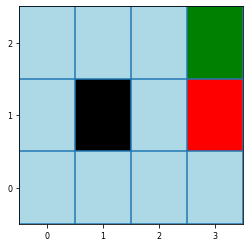

In [9]:
# Initialise our environment
grid_world = GridEnv(noise=0.2, living_reward=-0.04, gamma=0.99)

# Get policy shown in section 1
policy_pi = encode_policy(grid_world)

# Compute value-function using dynamic programming
v_pi = policy_evaluation(grid_world, policy_pi)

# Use value-function to compute q-values
q_pi = grid_world.get_q_values(v_pi)

# Start episode
cur_state = grid_world.idx_cur_state
s_x, s_y = get_state_to_plot(grid_world)

# We can visualize our grid world using the render() function
fig, ax = grid_world.render()
agent, = ax.plot([], [], 'o', color='b', linewidth=6)
reward_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

done = False
cumulative_reward = 0
path_to_plot = []

v_epsilon = 0.8

while not done:
    action = get_egreedy_action(grid_world, cur_state, q_pi, v_epsilon)
    cur_state, cur_reward, done, _ = grid_world.step(int(action))
    n_x, n_y = get_state_to_plot(grid_world)
    cumulative_reward += cur_reward
    path_to_plot.append([cumulative_reward, n_x, n_y])

def init():
    agent.set_data(s_x + 0.5, s_y + 0.5)
    reward_text.set_text('')
    return agent, reward_text

def animate(i):
    if i < len(path_to_plot):
        r, n_x, n_y = path_to_plot[i]
        agent.set_data(n_x + 0.5, n_y + 0.5)
        reward_text.set_text('Cumulative reward: %.2f' % r)
    return agent, reward_text

In [10]:
ani = animation.FuncAnimation(fig, animate, frames=len(path_to_plot), blit=False, interval=500, init_func=init,
                              repeat=False)

HTML(ani.to_html5_video())

## 3.2 Q-Learning

We have seen how to evaluate a policy without a model. Let's now find an *approximately* optimal policy using the off-policy control method Q-learning.

To help during the learning, we have added a lambda function that iteratively decreases epsilon. Our agent will strongly explore the environment at first to then swicth into exploitation mode

In [11]:
min_epsilon=0.001
max_epsilon=1.0
epsilon_decay = 80.0
epsilon_by_episode = lambda ep_idx: min_epsilon + (max_epsilon - min_epsilon) * math.exp (-1 * ep_idx/epsilon_decay)

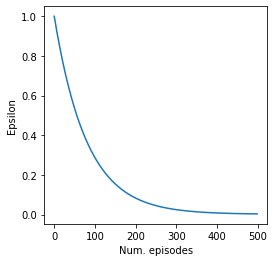

In [12]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot([epsilon_by_episode(i) for i in range(500)])
ax.set_xlabel("Num. episodes")
ax.set_ylabel("Epsilon")

plt.show()

Here is our implementation of the q-learning algorithm shown below

![](https://raw.githubusercontent.com/Tobias-Fischer/RVSS2022/main/Reinforcement_Learning/Support/images/q-learning.png)

**Complete the missing steps**:
- Choose an action using an $\epsilon$-greedy policy (use the function ``get_egreedy_action(.)`` we tested in section 2)
- Update our q-function using a greedy (max) policy (use ``q_function[cur_state][action]`` to index our q-function)

**Keep in Mind**: Correspondance between the mathematical notation ($\alpha$) and implemented code

<table style="width:20%">
<thead>
<tr>
<th style="width:150px;font-size:20px;text-align:center;">Notation</th>
<th colspan=2, style="width:450px;font-size:20px;text-align:center;">Code</th>
</tr>
    <tr>
        <td></td>
        <th style="font-size:15px;text-align:center;">Variable/Attribute</th>
        <th style="font-size:15px;text-align:center;">Type</th>
    </tr>
</thead>
<tbody>
<tr>
    <td style="text-align:left;">$\epsilon$</td>
    <td style="text-align:left;font-size:15px;">epsilon_by_episode</td>
    <td>float</td>
</tr>
<tr>
    <td style="text-align:left;">$\alpha$</td>
    <td style="text-align:left;font-size:15px;">alpha</td>
    <td>float</td>
</tr>
<tr>
    <td style="text-align:left;">$\gamma$</td>
    <td style="text-align:left;font-size:15px;">grid_world.gamma</td>
    <td>float</td>
</tr>
<tr>
    <td style="text-align:left;">$\hat{q}(s, a)$</td>
    <td style="text-align:left;font-size:15px;">q_function[idx_s][idx_a]</td>
    <td>dict of dict</td>
</tr>
<tr>
    <td style="text-align:left;">$s$</td>
    <td style="text-align:left;font-size:15px;">cur_state</td>
    <td>int</td>
</tr>
<tr>
    <td style="text-align:left;">$r$</td>
    <td style="text-align:left;font-size:15px;">reward</td>
    <td>int</td>
</tr>
<tr>
    <td style="text-align:left;">$s'$</td>
    <td style="text-align:left;font-size:15px;">next_state</td>
    <td>int</td>
</tr>
</table>

In [13]:
def q_learning(grid_env, alpha=0.1, min_epsilon=0.01, max_epsilon=1.0, 
               epsilon_decay = 80.0, n_episodes=500):
    """
    This function computes an approximately optimal policy using q-learning
    
    :param grid_env (GridEnv): MDP environment
    :param alpha (float): step-size
    :param epsilon (float): value used during e-greedy action selection
    :return: (dict) State-values for all non-terminal states
    """
        
    # This lambda function iteratively decreases epsilon
    epsilon_by_episode = lambda ep_idx: min_epsilon + (max_epsilon - min_epsilon) * math.exp (-1 * ep_idx/epsilon_decay)
    
    # Obtain list of all states in environment
    states = grid_env.get_states()
    actions = grid_env.get_actions()
    q_function = defaultdict(lambda: defaultdict(float))
    
    # Initialize q_function arbitrarily
    for s in states:
        for a in actions:
            q_function[s][a] = 0
    
    
    for i_episode in range(1, n_episodes+1):
        cur_state = grid_env.reset()
        done = False
        epsilon = epsilon_by_episode(i_episode)
        
        while not done:
            # TODO 1: Complete off-policy action selection (e-greedy)
            action = 0

            next_state, reward, done,_ = grid_env.step(action)
            q_next_state = list(q_function[next_state].values())
            
            # TODO 2: Complete update of q-function
            q_function[cur_state][action] += 0
            
            cur_state=next_state
    
    return decode_policy(grid_env, q_function)

Let's now test our implementation and compare our free-model policy with the one we obtained using value iteration (another DP algorithm)

In [14]:
grid_world = GridEnv(gamma=0.9, noise=0.2, living_reward=-0.04)
q_learning_policy = q_learning(grid_world)

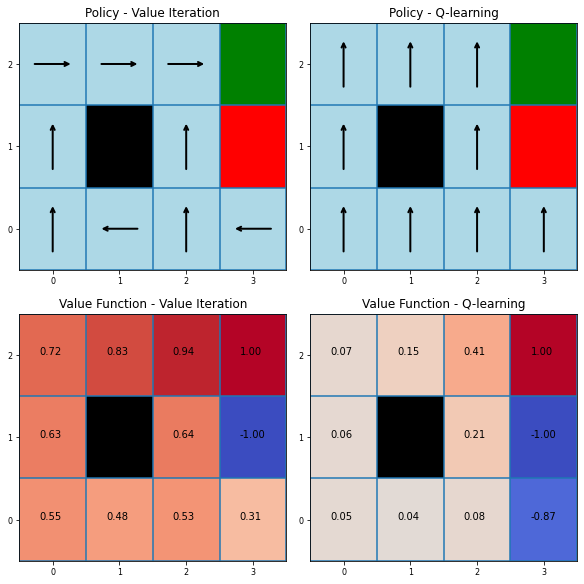

In [16]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
f_ax1 = fig.add_subplot(spec[0, 0])
f_ax2 = fig.add_subplot(spec[0, 1])
f_ax3 = fig.add_subplot(spec[1, 0])
f_ax4 = fig.add_subplot(spec[1, 1])

#Plot policy obtained using value-iteration value function
grid_world = GridEnv(gamma=0.9, noise=0.2, living_reward=0)
value_function, optimal_policy = value_iteration(grid_world)

plot_policy(grid_world, optimal_policy, f_ax1)
f_ax1.set_title("Policy - Value Iteration")

plot_policy(grid_world, q_learning_policy, f_ax2)
f_ax2.set_title("Policy - Q-learning")

# Compute value function for q_learning policy
q_policy_state_values = policy_evaluation(grid_world, encode_policy(grid_world, q_learning_policy))

plot_value_function(grid_world, value_function, f_ax3)
f_ax3.set_title("Value Function - Value Iteration")

plot_value_function(grid_world, q_policy_state_values, f_ax4)
f_ax4.set_title("Value Function - Q-learning")

plt.show()